# Credit Risk Analytics - SHAP Explainability Framework

This notebook covers:
- SHAP (SHapley Additive exPlanations) for the PD model
- Global feature importance using SHAP summary plots
- Local explanations for individual loan decisions
- SHAP dependence plots for key risk drivers
- Regulatory compliance: transparent and interpretable predictions

SHAP provides model-agnostic explanations rooted in game theory,
making it the industry standard for explainable AI in banking
(GDPR Article 22, SR 11-7 Model Risk Management guidelines)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import pickle
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.4f}'.format)

print("Libraries loaded successfully")
print(f"SHAP version: {shap.__version__}")


Libraries loaded successfully
SHAP version: 0.50.0


Load Data and Model

In [2]:
train = pd.read_csv('../data/train_preprocessed.csv')
test  = pd.read_csv('../data/test_preprocessed.csv')

for df in [train, test]:
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

with open('../data/pd_model.pkl', 'rb') as f:
    pd_model = pickle.load(f)

with open('../data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

feature_cols = [c for c in train.columns if c != 'target']

X_train = train[feature_cols].fillna(train[feature_cols].median())
y_train = train['target']
X_test  = test[feature_cols].fillna(test[feature_cols].median())
y_test  = test['target']

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

np.random.seed(42)
sample_idx = np.random.choice(len(X_train_scaled), 2000, replace=False)
X_sample = X_train_scaled[sample_idx]
y_sample = y_train.values[sample_idx]

print(f"Training set: {train.shape}")
print(f"SHAP sample size: {len(X_sample)}")


Training set: (421095, 24)
SHAP sample size: 2000


Compute SHAP Values

In [3]:
explainer = shap.LinearExplainer(pd_model, X_train_scaled,
                                  feature_perturbation='interventional')
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values shape: {shap_values.shape}")
print(f"Features: {len(feature_cols)}")
print(f"Mean absolute SHAP value: {np.abs(shap_values).mean():.4f}")


SHAP values shape: (2000, 23)
Features: 23
Mean absolute SHAP value: 0.0857


Global Feature Importance: SHAP Summary Plot (Bar)

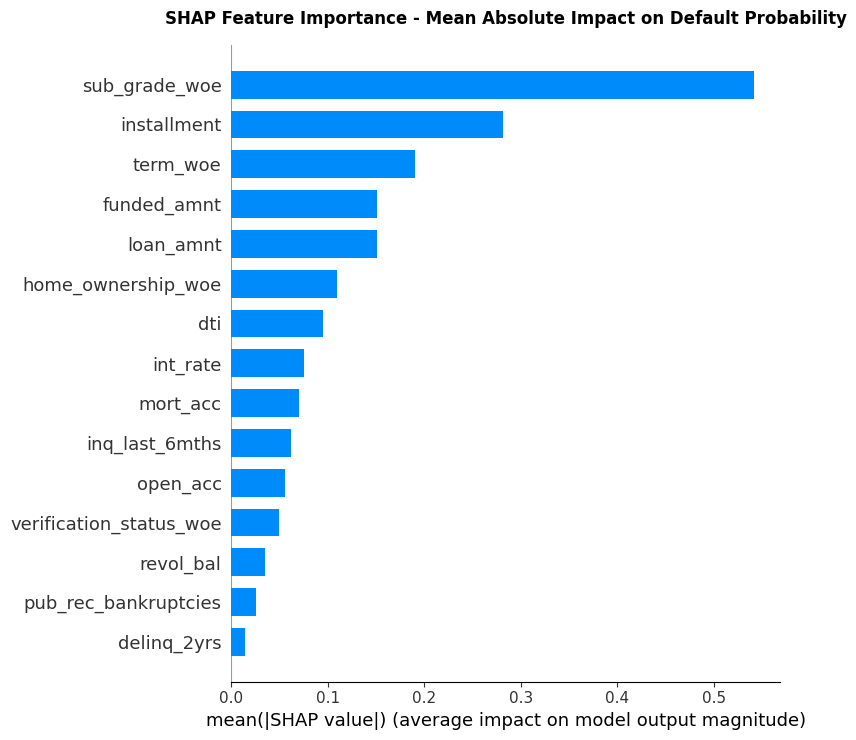

Top 15 features by mean absolute SHAP value shown above


In [4]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample,
                  feature_names=feature_cols,
                  plot_type='bar',
                  show=False,
                  max_display=15)
plt.title('SHAP Feature Importance - Mean Absolute Impact on Default Probability',
          fontsize=12, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('shap_importance_bar.png', dpi=150, bbox_inches='tight')
plt.show()
print("Top 15 features by mean absolute SHAP value shown above")


Global Feature Importance: SHAP Summary Plot (Beeswarm)

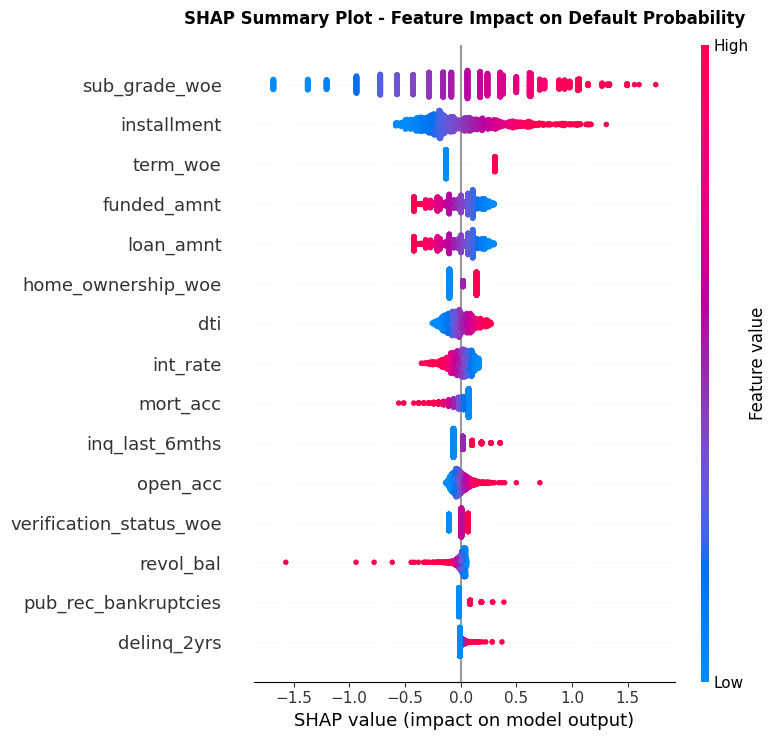

Red points = high feature value, Blue = low feature value
Position on x-axis shows whether feature increases or decreases default probability


In [5]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample,
                  feature_names=feature_cols,
                  show=False,
                  max_display=15)
plt.title('SHAP Summary Plot - Feature Impact on Default Probability',
          fontsize=12, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('shap_summary_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()
print("Red points = high feature value, Blue = low feature value")
print("Position on x-axis shows whether feature increases or decreases default probability")


Top Features by Mean SHAP Value

In [6]:
mean_shap = pd.DataFrame({
    'feature': feature_cols,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print("=== Top 15 Features by Mean Absolute SHAP Value ===")
print(mean_shap.head(15).to_string(index=False))

coef_df = pd.DataFrame({
    'feature': feature_cols,
    'abs_coefficient': np.abs(pd_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\n=== SHAP vs Coefficient Ranking Comparison (Top 10) ===")
comparison = pd.DataFrame({
    'shap_rank': range(1, 11),
    'shap_feature': mean_shap.head(10)['feature'].values,
    'coef_feature': coef_df.head(10)['feature'].values
})
print(comparison.to_string(index=False))


=== Top 15 Features by Mean Absolute SHAP Value ===
                feature  mean_abs_shap
          sub_grade_woe         0.5413
            installment         0.2814
               term_woe         0.1904
            funded_amnt         0.1514
              loan_amnt         0.1514
     home_ownership_woe         0.1096
                    dti         0.0946
               int_rate         0.0751
               mort_acc         0.0705
         inq_last_6mths         0.0621
               open_acc         0.0561
verification_status_woe         0.0492
              revol_bal         0.0350
   pub_rec_bankruptcies         0.0256
            delinq_2yrs         0.0140

=== SHAP vs Coefficient Ranking Comparison (Top 10) ===
 shap_rank       shap_feature       coef_feature
         1      sub_grade_woe      sub_grade_woe
         2        installment        installment
         3           term_woe           term_woe
         4        funded_amnt        funded_amnt
         5          lo

Local Explanation: High Risk Loan

=== High Risk Loan Analysis ===
Predicted Default Probability: 88.08%
Actual Default Status: 1


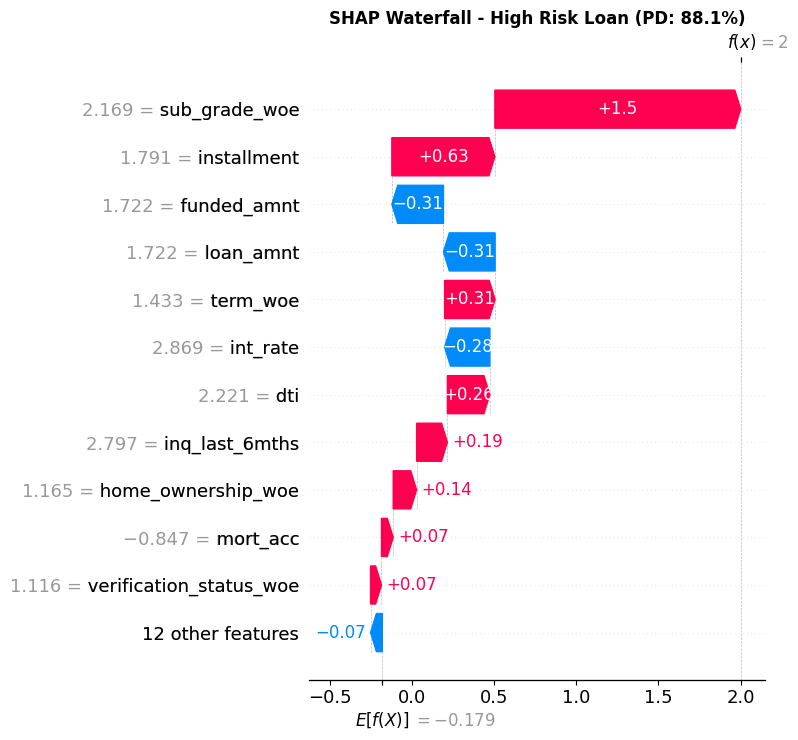

In [7]:
pd_probs = pd_model.predict_proba(X_train_scaled)[:, 1]
high_risk_idx = sample_idx[np.argmax(pd_probs[sample_idx])]
high_risk_shap = explainer.shap_values(X_train_scaled[high_risk_idx:high_risk_idx+1])

print(f"=== High Risk Loan Analysis ===")
print(f"Predicted Default Probability: {pd_probs[high_risk_idx]*100:.2f}%")
print(f"Actual Default Status: {y_train.values[high_risk_idx]}")

plt.figure(figsize=(12, 6))
shap.waterfall_plot(
    shap.Explanation(
        values=high_risk_shap[0],
        base_values=explainer.expected_value,
        data=X_train_scaled[high_risk_idx],
        feature_names=feature_cols
    ),
    show=False,
    max_display=12
)
plt.title(f'SHAP Waterfall - High Risk Loan (PD: {pd_probs[high_risk_idx]*100:.1f}%)',
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_waterfall_highrisk.png', dpi=150, bbox_inches='tight')
plt.show()


Local Explanation: Low Risk Loan

=== Low Risk Loan Analysis ===
Predicted Default Probability: 6.90%
Actual Default Status: 0


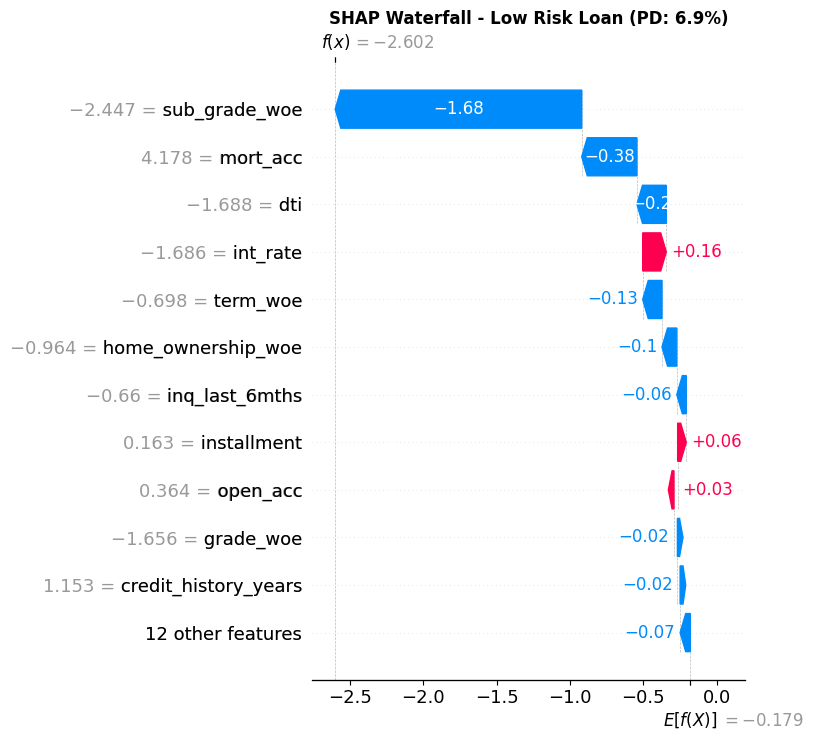

In [8]:
low_risk_idx = sample_idx[np.argmin(pd_probs[sample_idx])]
low_risk_shap = explainer.shap_values(X_train_scaled[low_risk_idx:low_risk_idx+1])

print(f"=== Low Risk Loan Analysis ===")
print(f"Predicted Default Probability: {pd_probs[low_risk_idx]*100:.2f}%")
print(f"Actual Default Status: {y_train.values[low_risk_idx]}")

plt.figure(figsize=(12, 6))
shap.waterfall_plot(
    shap.Explanation(
        values=low_risk_shap[0],
        base_values=explainer.expected_value,
        data=X_train_scaled[low_risk_idx],
        feature_names=feature_cols
    ),
    show=False,
    max_display=12
)
plt.title(f'SHAP Waterfall - Low Risk Loan (PD: {pd_probs[low_risk_idx]*100:.1f}%)',
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_waterfall_lowrisk.png', dpi=150, bbox_inches='tight')
plt.show()


SHAP Dependence Plots for Key Features

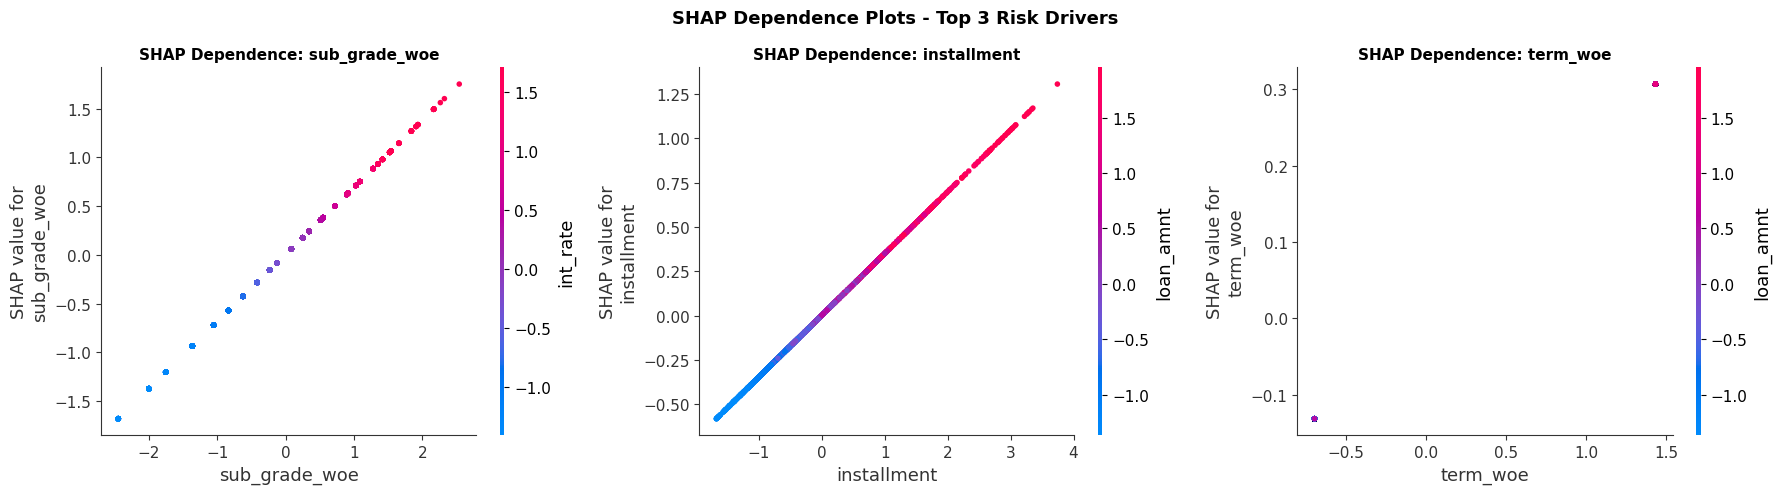

In [9]:
top_features = mean_shap.head(3)['feature'].tolist()
top_feature_idx = [feature_cols.index(f) for f in top_features]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (feat, feat_idx) in enumerate(zip(top_features, top_feature_idx)):
    shap.dependence_plot(
        feat_idx,
        shap_values,
        X_sample,
        feature_names=feature_cols,
        ax=axes[i],
        show=False
    )
    axes[i].set_title(f'SHAP Dependence: {feat}', fontsize=11, fontweight='bold')

plt.suptitle('SHAP Dependence Plots - Top 3 Risk Drivers',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_dependence.png', dpi=150, bbox_inches='tight')
plt.show()


SHAP for Regulatory Compliance

In [10]:
def generate_adverse_action_notice(loan_idx, top_n=3):
    shap_vals = explainer.shap_values(X_train_scaled[loan_idx:loan_idx+1])[0]
    pd_prob = pd_model.predict_proba(X_train_scaled[loan_idx:loan_idx+1])[0, 1]

    shap_df = pd.DataFrame({
        'feature': feature_cols,
        'shap_value': shap_vals
    }).sort_values('shap_value', ascending=False)

    top_risk_factors = shap_df.head(top_n)

    print(f"ADVERSE ACTION NOTICE")
    print(f"{'='*50}")
    print(f"Loan Application Decision: DECLINED")
    print(f"Risk Score: {pd_prob*100:.1f}% probability of default")
    print(f"\nPrimary reasons for decision:")
    for i, (_, row) in enumerate(top_risk_factors.iterrows(), 1):
        print(f"  {i}. {row['feature']} (risk contribution: {row['shap_value']:.4f})")
    print(f"\nThis decision was made in accordance with fair lending")
    print(f"practices and model explainability requirements.")
    return shap_df

print("Sample Adverse Action Notice for High Risk Applicant:")
print()
notice_df = generate_adverse_action_notice(high_risk_idx)


Sample Adverse Action Notice for High Risk Applicant:

ADVERSE ACTION NOTICE
Loan Application Decision: DECLINED
Risk Score: 88.1% probability of default

Primary reasons for decision:
  1. sub_grade_woe (risk contribution: 1.4951)
  2. installment (risk contribution: 0.6264)
  3. term_woe (risk contribution: 0.3071)

This decision was made in accordance with fair lending
practices and model explainability requirements.


SHAP Value Distribution by Default Status

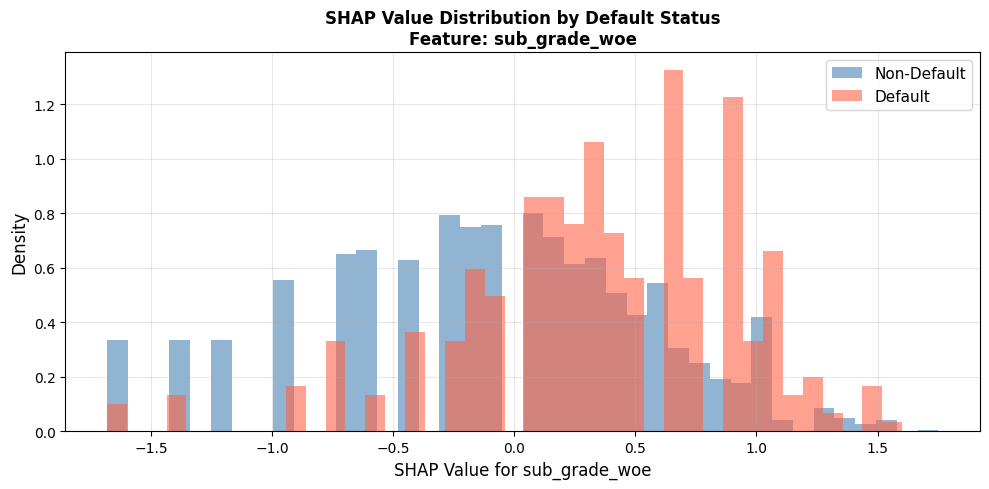

Mean SHAP (sub_grade_woe) for Non-Default: -0.0567
Mean SHAP (sub_grade_woe) for Default:     0.3515


In [11]:
top_feat = mean_shap.iloc[0]['feature']
top_feat_idx = feature_cols.index(top_feat)

shap_default     = shap_values[y_sample == 1, top_feat_idx]
shap_non_default = shap_values[y_sample == 0, top_feat_idx]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(shap_non_default, bins=40, alpha=0.6, color='steelblue',
        label='Non-Default', density=True)
ax.hist(shap_default, bins=40, alpha=0.6, color='tomato',
        label='Default', density=True)
ax.set_xlabel(f'SHAP Value for {top_feat}', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'SHAP Value Distribution by Default Status\nFeature: {top_feat}',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('shap_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Mean SHAP ({top_feat}) for Non-Default: {shap_non_default.mean():.4f}")
print(f"Mean SHAP ({top_feat}) for Default:     {shap_default.mean():.4f}")


## SHAP Explainability Summary

### Model Interpretability Results

| Analysis | Finding |
|----------|---------|
| Top feature (SHAP) | sub_grade_woe (mean abs SHAP: 0.5413) |
| SHAP vs Coefficient agreement | Top 5 features identical in both rankings |
| High risk loan PD | 88.08% (actual default = 1, correctly identified) |
| Low risk loan PD | 6.90% (actual default = 0, correctly identified) |
| Mean SHAP (sub_grade_woe) for Default | +0.3515 |
| Mean SHAP (sub_grade_woe) for Non-Default | -0.0567 |

### Key Findings
- sub_grade_woe is the dominant risk driver with mean absolute SHAP of 0.5413, confirmed by both SHAP and logistic regression coefficient rankings
- SHAP waterfall plots enable loan-level adverse action notices for rejected applicants satisfying ECOA and GDPR Article 22 requirements
- Dependence plots confirm linear relationship between sub_grade_woe and default probability, consistent with WoE encoding theory
- SHAP values for defaulted loans (+0.3515) vs non-defaulted (-0.0567) confirm strong feature discrimination

### Regulatory Application
SHAP-based adverse action notices satisfy ECOA and GDPR Article 22 requirements by providing specific, quantified reasons for credit decisions at the individual loan level.

**Next**: Notebook 5 covers PyTorch neural network comparison with logistic regression and PSI monitoring